# Setup

 Import standard modules

In [1]:
import pandas as pd
import numpy as np
import sys
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import time

Set root directory

In [2]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim" / "tides"

Import project modules

In [3]:
from tidal_flat_0d import models
from tidal_flat_0d import features
from tidal_flat_0d import visualization as viz

# Debug

In [ ]:
def below_platform(t, y, *args):
    depth = tide_spl(t) - (y[1] + depth_cutoff)
    return depth

below_platform.terminal = True
below_platform.direction = -1

def solve_ode(t, y, *args):

    # set initial values for concentration and elevation
    init_conc = y[0]
    init_elev = y[1]

    # use spline function for tide height to set current water_height
    water_height = tide_spl(t)
    depth = water_height - init_elev #calculate current depth

    # use derivative of tide spline to get current gradient and set H
    dhdt = dhdt_spl(t)

    if dhdt > 0:
        H = 1
    else:
        H = 0

    delta_conc = (- (settle_rate * init_conc) / depth - H / depth * (init_conc - bound_conc) * dhdt)
    delta_elev = settle_rate * (init_conc + delta_conc) / bulk_dens

    return [delta_conc, delta_elev]

In [ ]:
elev = init_elev
conc = 0
pos = 0
elevs = np.empty(0)
times = np.empty(0)
inundations = 0

results = []
start_time = time.perf_counter()
while True:
    remaining_data = data[pos:]
    data_above_platform = remaining_data[remaining_data.pressure > elev]

    if len(data_above_platform) < 4:
        end_time = time.perf_counter()
        print('Total accumulation: {:.4f} cm'.format((elev - init_elev) * 100))
        print('Final Elevation: {:.4f} m'.format(elev))
        print('Simulation completed in {:.0f} s'.format(end_time - start_time))
        break

    if len(np.where(np.diff(data_above_platform.num_index.values) != 1)[0]) == 0:
        end = len(data_above_platform) - 1
    else:
        end = np.where(np.diff(data_above_platform.num_index.values) != 1)[0][0] + 1

    subset = data_above_platform[:end].resample('1S').interpolate(method='linear')

    if len(subset) < 4:
        pos = subset.num_index.values[-1] + 1
        continue

    subset_water_height = subset.pressure.values
    subset_index = subset.num_index.values

    tide_spl = InterpolatedUnivariateSpline(subset_index, subset_water_height)
    dhdt_spl = tide_spl.derivative()
    depth_spl = InterpolatedUnivariateSpline(subset_index, subset_water_height - (elev + depth_cutoff))

    t_span = [subset_index[0], subset_index[-1]]
    result = solve_ivp(fun=solve_ode, t_span=t_span, y0=[conc, elev], events=below_platform,
                           args=(bound_conc, settle_rate, bulk_dens, depth_cutoff), dense_output=True)
    times = np.concatenate((times, result.t))
    elevs = np.concatenate((elevs, result.y[1]))

    elev = result.y[1][-1]
    pos = subset.index.values[-1] + 1
    inundations += 1
    results.append(result)

# Run Model

In [37]:
timestep = 1
# tide_name = "tides-debug-{}s.feather".format(timestep)
tide_name = 'tides-1yr-{}s.feather'.format(timestep)
tides = features.load_tide(wdir, tide_name)
tides = pd.Series(data=tides.pressure.values, index=pd.DatetimeIndex(data=tides.index.values, freq="infer"))
#resampled_tides = tides.resample('1S').interpolate(method='linear')
#data = pd.Series(data=resampled_tides.values)
data = pd.Series(tides.values)
# data = pd.DataFrame(data = {'num_index': np.arange(0, len(tides)), 'pressure':tides.values}, index=tides.index)

grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)

bound_conc = 0.8
bulk_dens = 1100
init_elev = 0

depth_cutoff = 0.001
years = 25
slr = 0.005

tide_spl = InterpolatedUnivariateSpline(np.arange(0, len(data)), data)
dhdt_spl = tide_spl.derivative()

In [38]:
times = np.empty(0)
concs = np.empty(0)
elevs = np.empty(0)
elev = init_elev
water_heights = data.values
start_time = time.perf_counter()
for year in range(0, years):
    water_heights = water_heights + (year * slr)
    t, c, z = models.aggrade(water_heights=water_heights, settle_rate=settle_rate, bulk_dens=bulk_dens, 
                               bound_conc=bound_conc, init_elev=elev, init_conc=0, timestep=timestep, depth_cutoff=depth_cutoff)
    times = np.concatenate((times, t + (len(water_heights) * year)))
    concs = np.concatenate((concs, c))
    elevs = np.concatenate((elevs, z))
    elev = elevs[-1]
end_time = time.perf_counter()

print('Total accumulation: {:.4f} cm'.format((elev - init_elev) * 100))
print('Final Elevation: {:.4f} m'.format(elev))
print('Simulation completed in {:.0f} s'.format(end_time - start_time))

Total accumulation: 265.4681 cm
Final Elevation: 2.6547 m
Simulation completed in 1248 s


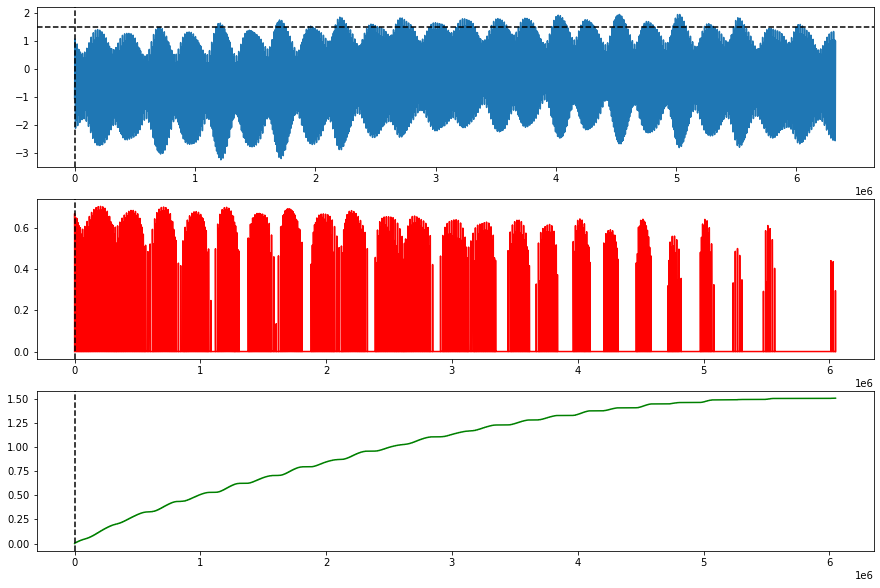

In [34]:
plt_data = data
t = times
c = concs
z = elevs

slack = plt_data.index.values[np.where(dhdt_spl(plt_data.index) < 0)[0][0]]
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].plot(plt_data)
axs[0].axhline(elev + depth_cutoff, ls='--', color='black')
axs[1].plot(t, c, color='r')
axs[2].plot(t, z, color='g')
for ax in axs:
    ax.axvline(slack, ls='--', color='black')

In [ ]:
results = [sim]
t = np.empty(0)
c = np.empty(0)
z = np.empty(0)
plt_data = data[t_span[0]:t_span[-1]]
for result in results:
    t = np.concatenate((t, result.t))
    c = np.concatenate((z, result.y[0]))
    z = np.concatenate((z, result.y[1]))

slack = plt_data.index.values[np.where(dhdt_spl(plt_data.index) < 0)[0][0]]
fig, axs = plt.subplots(3, 1)
fig.set_figheight(10)
fig.set_figwidth(15)
axs[0].plot(plt_data)
axs[0].axhline(elev + depth_cutoff, ls='--', color='black')
axs[1].plot(t, c, color='r')
axs[2].plot(t, z, color='g')
for ax in axs:
    ax.axvline(slack, ls='--', color='black')

# Plot results